In [1]:
!pip install "line_profiler[ipython]" ipython==8.5.0 ffmpeg-python imutils==0.5.4 sahi scikit-learn supervision openai ipywidgets

#### First, generate a presentation for every section in our video. This includes loading the cleaned up ball detections for the video

In [18]:
import supervision as sv
import cv2
import sys
import os

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(parent_dir)

from core.detections import load_video_detections, Detections

video_path = "/home/luis/workspace/vacocam_render/experiments/vacocam/source/prerender.mp4"
_, detections = load_video_detections(video_path, module="track", version="declustered")

seconds = 10

video_info = sv.VideoInfo.from_video_path(video_path)

framerate = video_info.fps
total_frames = video_info.total_frames or 0

frame_indices = [(i * seconds * framerate, (i + 1) * seconds * framerate) for i in range(int(total_frames / (seconds * framerate)))]
if frame_indices[-1][1] != total_frames:
    frame_indices.append((frame_indices[-1][1], total_frames))

def make_video_section(start, end):
    dets = detections[start:end]
    # find a frame in the middle of the section, but provided it has detections
    mid = int((start + end) / 2)

    while len(detections[mid]) == 0:
        mid += 1

    cap = cv2.VideoCapture(video_path)

    cap.set(cv2.CAP_PROP_POS_FRAMES, mid)
    ret, sample = cap.read()
    
    if not ret:
        raise Exception("Error reading video")

    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    cap.release()
    return (dets, sample)

loading detections from /home/luis/workspace/vacocam/experiments/vacocam/source/track/prerender_detections_declustered.npy
loaded 112300 detections from /home/luis/workspace/vacocam/experiments/vacocam/source/track/prerender_detections_declustered.npy


In [3]:
# cluster detections and find overlaps

from tracking import cluster_detections, get_artifact_id

overlaps = {}

for start, end in frame_indices:
    section_detections = detections[start:end]
    clustered_detections: dict[int, list[Detections]] = cluster_detections(section_detections, preset="play")

    clustered_detections_minus_noise: dict[int, list[Detections]] = { key: detections for key, detections in clustered_detections.items() if key != -1 }

    # find clusters start and ends
    start_ends: dict[int, tuple[int, int]] = { key: (0, 0) for key in clustered_detections_minus_noise.keys() }

    for key, c_detections in clustered_detections_minus_noise.items():
        # find start of the cluster, meaning the index of the first detection that is not empty. (len(detection) > 0)
        cluster_start = 0
        for i, detection in enumerate(c_detections):
            if len(detection) > 0:
                cluster_start = i
                break
        # find end of the cluster, meaning the index of the last detection that is not empty. (len(detection) > 0)
        cluster_end = 0
        for i, detection in enumerate(reversed(c_detections)):
            if len(detection) > 0:
                cluster_end = len(c_detections) - i
                break
        start_ends[key] = (cluster_start, cluster_end)
    
    # now find any overlapping clusters
    overlapping_clusters = {}

    for key1, (start1, end1) in start_ends.items():
        for key2, (start2, end2) in start_ends.items():
            if key1 != key2 and start1 < end2 and end1 > start2:
                overlap = min(end1, end2) - max(start1, start2)

                if (key1, key2) in overlapping_clusters or (key2, key1) in overlapping_clusters:
                    continue
                if overlap < min(end1 - start1, end2 - start2) * 0.5:
                    continue
                if end1 - start1 < 15 or end2 - start2 < 15 or overlap < 15:
                    continue

                overlapping_clusters[(key1, key2)] = {
                    "overlap": min(end1, end2) - max(start1, start2),
                    "clusters": {
                        key1: clustered_detections_minus_noise[key1],
                        key2: clustered_detections_minus_noise[key2]
                    },
                    "bounds": {
                        key1: (start + start1, start + end1),
                        key2: (start + start2, start + end2)
                    },
                }


    if len(overlapping_clusters) > 0:
        overlaps[(start, end)] = overlapping_clusters

print("[VacomCam] Done finding overlaps")
print("[VacomCam] Found {} overlaps".format(sum([len(value) for value in overlaps.values()])))

[VacomCam] Done finding overlaps
[VacomCam] Found 24 overlaps


In [4]:
# save presented sections to disk

%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
from io import BytesIO

from tracking import present_section, save_section_presentation

# print overlaps ordered by overlap time descendent
overlaps = { key: value for key, value in sorted(overlaps.items(), key=lambda item: sum([va["overlap"] for va in item[1].values()]), reverse=True) }

# lets also make a video of the overlaps for easier viewing
v_out = cv2.VideoWriter("overlaps.mp4", cv2.VideoWriter_fourcc(*'mp4v'), framerate, (1920, 1080))

for (section_start, section_end), overlapping_clusters in overlaps.items():
    formatted_start = f"{int(section_start / framerate / 60)}:{int(section_start / framerate % 60)}"
    formatted_end = f"{int(section_end / framerate / 60)}:{int(section_end / framerate % 60)}"

    print(f"{formatted_start} - {formatted_end}")

    for (key1, key2), overlap_data in overlapping_clusters.items():
        start1, end1 = overlap_data["bounds"][key1]
        start2, end2 = overlap_data["bounds"][key2]

        start = min(start1, start2)
        end = max(end1, end2)

        print(f"\t{key1} - {key2} ({overlap_data['overlap']} frames overlap)")
        formatted_start = f"{int(start / framerate / 60)}:{int(start / framerate % 60)}"
        formatted_end = f"{int(end / framerate / 60)}:{int(end / framerate % 60)}"
        print(f"\t\t{formatted_start} - {formatted_end}")

        artifact_id = get_artifact_id(video_path, start, end, framerate)

        _section_detections, sample = make_video_section(start, end)

        section_img, section_metadata = present_section(sample, overlap_data["clusters"], version="v3")
        
        save_section_presentation(artifact_id, section_img, section_metadata)

        video_frame = np.array(Image.open(BytesIO(section_img)))
        v_out.write(cv2.cvtColor(video_frame, cv2.COLOR_RGB2BGR))

v_out.release()

42:40 - 42:50
	0 - 1 (128 frames overlap)
		42:40 - 42:48
55:50 - 56:0
	0 - 1 (73 frames overlap)
		55:50 - 55:59
	1 - 2 (49 frames overlap)
		55:54 - 55:59
50:10 - 50:20
	1 - 2 (98 frames overlap)
		50:10 - 50:18
11:40 - 11:50
	0 - 1 (93 frames overlap)
		11:42 - 11:50
25:10 - 25:20
	0 - 1 (92 frames overlap)
		25:10 - 25:19
9:10 - 9:20
	1 - 2 (77 frames overlap)
		9:15 - 9:20
42:20 - 42:30
	0 - 1 (75 frames overlap)
		42:20 - 42:26
57:30 - 57:40
	2 - 5 (75 frames overlap)
		57:35 - 57:40
18:50 - 19:0
	1 - 2 (73 frames overlap)
		18:53 - 18:59
5:40 - 5:50
	0 - 1 (68 frames overlap)
		5:40 - 5:44
9:30 - 9:40
	0 - 1 (64 frames overlap)
		9:30 - 9:36
5:30 - 5:40
	0 - 1 (60 frames overlap)
		5:30 - 5:37
43:40 - 43:50
	1 - 2 (57 frames overlap)
		43:43 - 43:48
35:30 - 35:40
	4 - 5 (54 frames overlap)
		35:34 - 35:40
No cluster angles for cluster  5
6:10 - 6:20
	0 - 1 (45 frames overlap)
		6:12 - 6:19
53:0 - 53:10
	0 - 1 (42 frames overlap)
		53:0 - 53:3
6:0 - 6:10
	2 - 4 (39 frames overlap

#### Cleanup and setup

Now that the sections have been generated, go and manually delete the ones you dont need. (image and metadata)

Then, run the code below:

In [2]:
import os
import matplotlib.pyplot as plt

pngs = [f for f in os.listdir("./.track/presentation") if f.endswith(".png")]
artifact_ids = [os.path.basename(f).replace(".png", "") for f in pngs]

if not os.path.exists("./.track/ground_truth"):
    os.makedirs("./.track/ground_truth")

for png in pngs:
    csv = png.replace(".png", ".csv")

    if not os.path.isfile(os.path.join("./.track/ground_truth", csv)):
        open(os.path.join("./.track/ground_truth", csv), "w").close()

def load_ground_truth(artifact_id) -> dict[str, bool] | None:
    ## example ground truth file:
    ## A, True
    ## B, False

    output_dir = os.path.join(os.getcwd(), ".track", "ground_truth")

    file_path = os.path.join(output_dir, artifact_id + ".csv")

    if os.path.exists(file_path):
        if os.path.getsize(file_path) == 0:
            return None

        with open(file_path, "r") as f:
            file_contents = f.read()
        
        res = {}

        for line in file_contents.split("\n"):
            if line.strip() != "":
                key = line.split(",")[0].strip().upper()
                value = line.split(",")[1].strip()

                res[key] = value in ["True", "true", "1", "yes", "Yes", "YES"]

        return res
    else:
        print(f"File {file_path} does not exist")
        
        return None

def get_score(ground_truth: dict[str, bool], response: dict[str, bool]) -> float:
    if len(ground_truth) == 0:
        return 0

    score = 0
    for key in ground_truth:
        if key not in response.keys():
            print(f"Key {key} not in response, skipping")
            continue

        if ground_truth[key] == response[key]:
            score += 1
    
    print(f"Expected: [{ground_truth}]")
    print(f"Received: [{response}]")
    
    return score / len(ground_truth)

def calc_scores():
    ground_truths = [{}] * len(artifact_ids)
    scores = [0.0] * len(artifact_ids)

    for idx, artifact_id in enumerate(artifact_ids):
        ground_truth = load_ground_truth(artifact_id)

        if ground_truth is None:
            print(f"Ground truth for {artifact_id} does not exist, skipping")
            continue
        else:
            print(f"Loaded ground truth for {artifact_id}")

        ground_truths[idx] = ground_truth

        response = responses[idx]

        score = get_score(ground_truth, response)

        print(f"Score: {score}\n")

        scores[idx] = score

    print(f"Overall score: {sum(scores) / len(scores)}")

    # show a dot for every data point int the graph, and also a line connecting them
    # also show the id next to the dot, rotated 90 degrees
    plt.plot(scores, 'o-')

    for idx, score in enumerate(scores):
        plt.text(idx, score, artifact_ids[idx], ha='center', va='center', fontsize=8, rotation=90)

    plt.show()

#### Now, call gpt4 vision for each presented section in our dataset

In [11]:
%load_ext autoreload
%autoreload 2

from tracking import load_section_presentation, load_gpt4_response, save_gpt4_response, parse_gpt4_response, ask_gippity_for_primary_clusters

responses = [{}] * len(artifact_ids)

for idx, artifact_id in enumerate(artifact_ids):
    section_img, section_metadata = load_section_presentation(artifact_id)

    if section_img is None or section_metadata is None:
        raise Exception("Error loading section presentation")

    print(f"[VacomCam] Submitting section to GPT-4 ({artifact_id})")
    loaded_response = load_gpt4_response(artifact_id)

    if loaded_response is not None:
        gpt4_response = loaded_response
    else:
        gpt4_response = ask_gippity_for_primary_clusters(section_img, section_metadata, version="v3")
    
        if gpt4_response is None:
            print("GPT-4 response was None, SAVING EMPTY RESPONSE")

        save_gpt4_response(artifact_id, gpt4_response)

    gpt4_response_parsed = parse_gpt4_response(gpt4_response)

    if gpt4_response_parsed is None:
        print("GPT-4 response could not be parsed, skipping section")
        continue

    responses[idx] = gpt4_response_parsed

print("[VacomCam] Done processing video sections")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[VacomCam] Submitting section to GPT-4 (prerender.mp4_55-54_55-59)
Parsed GPT-4 response
{'B': True, 'C': False}
[VacomCam] Submitting section to GPT-4 (prerender.mp4_42-20_42-26)
Parsed GPT-4 response
{'A': True, 'B': False}
[VacomCam] Submitting section to GPT-4 (prerender.mp4_50-10_50-18)
Parsed GPT-4 response
{'B': True, 'C': False}
[VacomCam] Submitting section to GPT-4 (prerender.mp4_55-50_55-59)
Parsed GPT-4 response
{'A': True, 'B': False}
[VacomCam] Submitting section to GPT-4 (prerender.mp4_26-30_26-39)
Parsed GPT-4 response
{'A': True, 'B': False}
[VacomCam] Submitting section to GPT-4 (prerender.mp4_57-35_57-40)
Parsed GPT-4 response
{'F': True, 'C': False}
[VacomCam] Submitting section to GPT-4 (prerender.mp4_02-13_02-19)
Parsed GPT-4 response
{'B': True, 'C': False}
[VacomCam] Submitting section to GPT-4 (prerender.mp4_05-40_05-44)
Parsed GPT-4 response
{'A': True, 'B': False}
[VacomCa

Loaded ground truth for prerender.mp4_55-54_55-59
Expected: [{'B': True, 'C': False}]
Received: [{'B': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_42-20_42-26
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_50-10_50-18
Expected: [{'C': False, 'B': True}]
Received: [{'B': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_55-50_55-59
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_26-30_26-39
Expected: [{'A': True, 'B': True}]
Received: [{'A': True, 'B': False}]
Score: 0.5

Loaded ground truth for prerender.mp4_57-35_57-40
Expected: [{'F': True, 'C': False}]
Received: [{'F': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_02-13_02-19
Expected: [{'B': False, 'C': True}]
Received: [{'B': True, 'C': False}]
Score: 0.0

Loaded ground truth for prerender.mp4_05-40_05-44
Expected: [{'

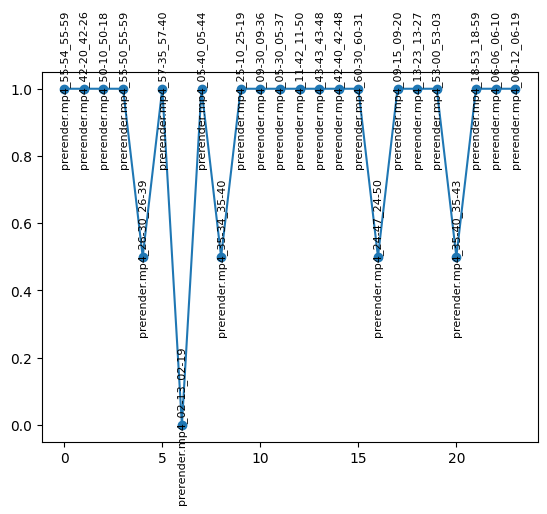

In [13]:
# v3 arrows
calc_scores()

Loaded ground truth for prerender.mp4_55-54_55-59
Expected: [{'B': True, 'C': False}]
Received: [{'B': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_42-20_42-26
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_50-10_50-18
Expected: [{'C': False, 'B': True}]
Received: [{'B': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_55-50_55-59
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_26-30_26-39
Expected: [{'A': True, 'B': True}]
Received: [{'A': True, 'B': False}]
Score: 0.5

Loaded ground truth for prerender.mp4_57-35_57-40
Expected: [{'F': True, 'C': False}]
Received: [{'F': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_02-13_02-19
Expected: [{'B': False, 'C': True}]
Received: [{'B': True, 'C': False}]
Score: 0.0

Loaded ground truth for prerender.mp4_05-40_05-44
Expected: [{'

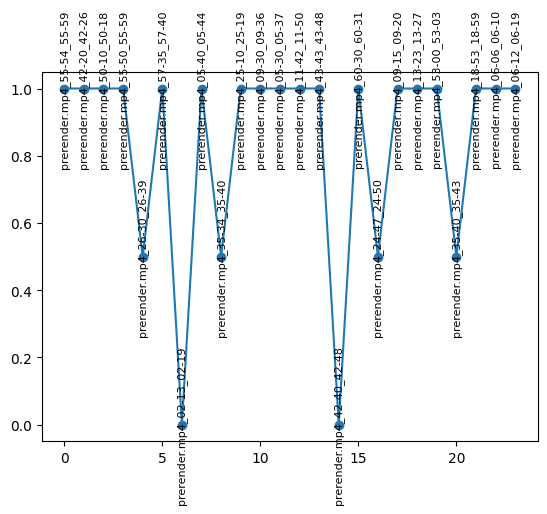

In [26]:
# v3 no arrows
calc_scores()

Loaded ground truth for prerender.mp4_55-54_55-59
Expected: [{'B': True, 'C': False}]
Received: [{'C': True, 'B': False}]
Score: 0.0

Loaded ground truth for prerender.mp4_42-20_42-26
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_50-10_50-18
Expected: [{'C': False, 'B': True}]
Received: [{'B': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_55-50_55-59
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_26-30_26-39
Expected: [{'A': True, 'B': True}]
Received: [{'A': True, 'B': False}]
Score: 0.5

Loaded ground truth for prerender.mp4_57-35_57-40
Expected: [{'F': True, 'C': False}]
Received: [{'F': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_02-13_02-19
Expected: [{'B': False, 'C': True}]
Received: [{'C': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_05-40_05-44
Expected: [{'

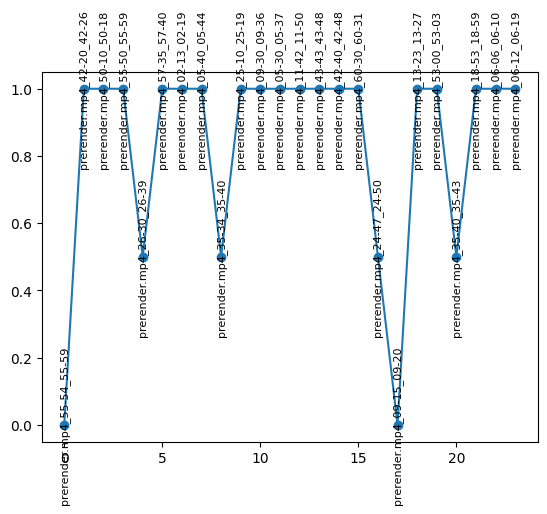

In [ ]:
calc_scores()

Loaded ground truth for prerender.mp4_55-54_55-59
Expected: [{'B': True, 'C': False}]
Received: [{'C': True, 'B': False}]
Score: 0.0

Loaded ground truth for prerender.mp4_42-20_42-26
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_50-10_50-18
Expected: [{'C': False, 'B': True}]
Received: [{'B': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_55-50_55-59
Expected: [{'A': True, 'B': False}]
Received: [{'A': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_26-30_26-39
Expected: [{'A': True, 'B': True}]
Received: [{'B': True, 'A': False}]
Score: 0.5

Loaded ground truth for prerender.mp4_57-35_57-40
Expected: [{'F': True, 'C': False}]
Received: [{'F': True, 'C': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_02-13_02-19
Expected: [{'B': False, 'C': True}]
Received: [{'C': True, 'B': False}]
Score: 1.0

Loaded ground truth for prerender.mp4_05-40_05-44
Expected: [{'

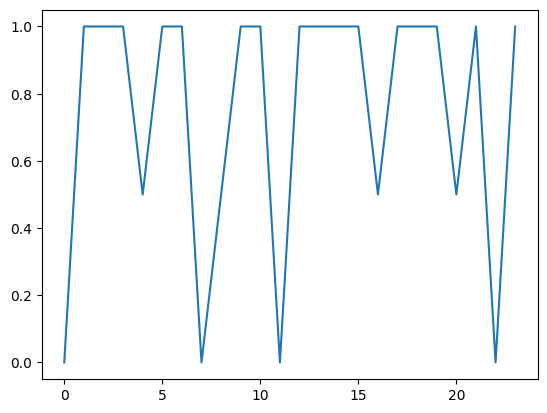

In [ ]:
calc_scores()

Overall score: 0.5576923076923077


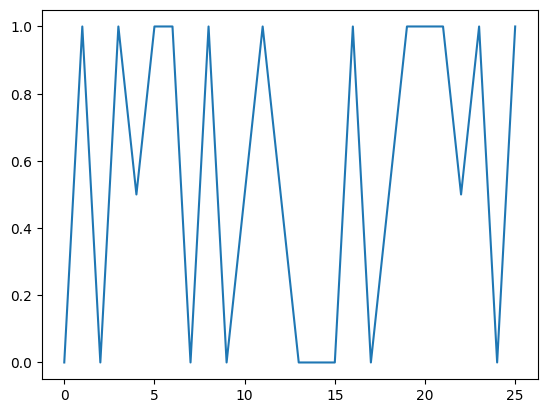

In [5]:
calc_scores()

Overall score: 0.6730769230769231


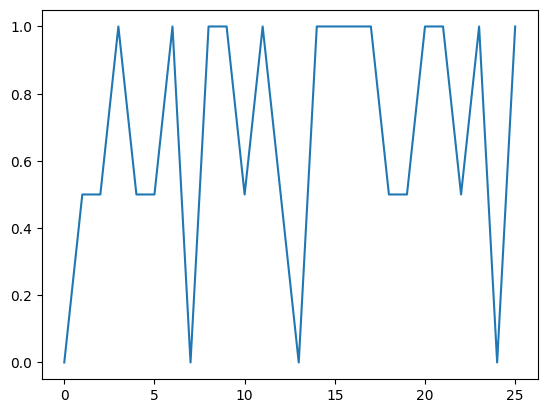

In [ ]:
calc_scores()